In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from scipy.constants import k, Boltzmann

In [2]:
def load_image(filename, size_x, size_y):
    with open(filename, 'rb') as fid:
        imageData = np.fromfile(fid, np.float32).reshape(size_x, size_y).T
        return imageData

resolution_x=300   
resolution_y=1000

### Importing data

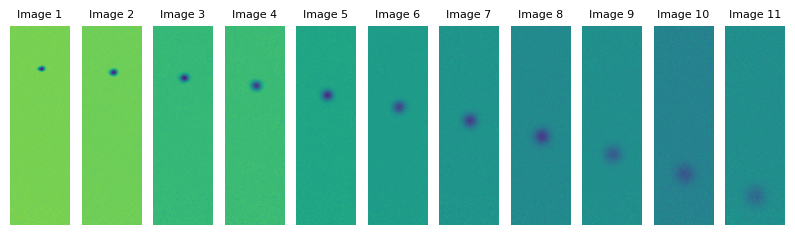

In [3]:
imdata = []  

for i in range(1, 12):
    t = f'A_Thermal_{i}.bin'  
    data = load_image(t, resolution_x, resolution_y) 
    imdata.append(data)

fig, axes = plt.subplots(1, 11, figsize=(10, 10)) 

for i, (ax, im) in enumerate(zip(axes, imdata)):  
    ax.imshow(im)  
    ax.axis('off') 
    ax.set_title(f"Image {i+1}", fontsize=8)

plt.show() 

### column density from I/I0 values

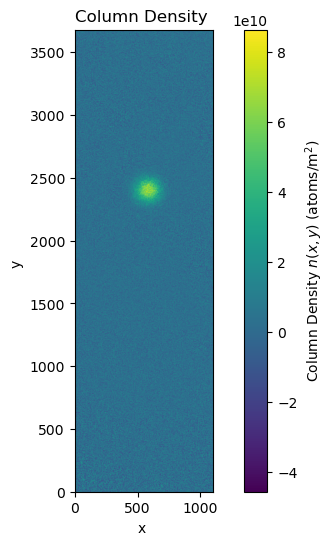

In [4]:
sigma_abs = 29e-13  
pixel_size = 3.68e-6  
res_x = 300
res_y = 1000
transmitted_image = load_image('A_Thermal_5.bin', res_x, res_y)

column_density = -np.log(transmitted_image ) / sigma_abs

# Plot the column density as a 2D image
plt.figure(figsize=(8, 6))
plt.imshow(column_density, extent=[0, column_density.shape[1] * pixel_size * 1e6,
                                                   0, column_density.shape[0] * pixel_size * 1e6])
plt.colorbar(label=r'Column Density $n(x, y)$ (atoms/m$^2$)')
plt.xlabel('x ')
plt.ylabel('y ')
plt.title('Column Density ')
plt.show()

### 1D gaussian (integrating out x-axis)

Fitted parameters:
A = 2989903168078.277, x0 = 347.6575007983802, sigma = -17.64326146960082, offset = 835667457610.5565


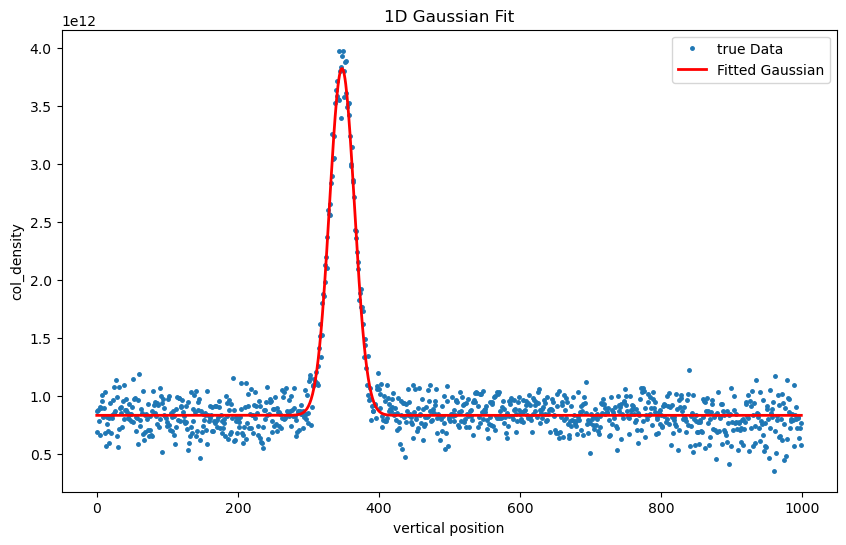

In [5]:
imageData = load_image('A_Thermal_5.bin', resolution_x, resolution_y)
col_density = -np.log(imageData ) / sigma_abs
def gaussian_1d(x, A, x0, sigma, offset):
    return A * (np.exp(-(x - x0)**2 / (2 * sigma**2))) + offset

y_data = np.sum(col_density, axis=1)
x = np.arange(1000)
A_guess = (np.max(y_data) - np.min(y_data) )
x0_guess = np.mean(x)
sigma_guess = np.std(x)
offset_guess = np.min(y_data)
initial_guess = [A_guess, x0_guess, sigma_guess, offset_guess]

#1d fit

popt, pcov = curve_fit(gaussian_1d,x, y_data, p0=initial_guess)

A_fit, x0_fit, sigma_fit, offset_fit = popt
print("Fitted parameters:")
print(f"A = {A_fit}, x0 = {x0_fit}, sigma = {sigma_fit}, offset = {offset_fit}")

y_fit = gaussian_1d(x, *popt)

plt.figure(figsize=(10, 6))
plt.plot(x, y_data, '.', label='true Data', markersize=5)
plt.plot(x, y_fit, 'r-', label='Fitted Gaussian', linewidth=2)
plt.xlabel('vertical position')
plt.ylabel('col_density')
plt.title('1D Gaussian Fit')
plt.legend()
plt.show()

In [6]:
def fit_fun(image_data):
    sigma_abs = 29e-13 
    column_density = -np.log(image_data ) / sigma_abs
    y_data = np.sum(column_density, axis=1)
    x = np.arange(len(y_data))
    A_guess = np.max(y_data) - np.min(y_data)
    x0_guess = np.argmax(y_data)
    sigma_guess = np.std(x)
    offset_guess = np.min(y_data)
    initial_guess = [A_guess, x0_guess, sigma_guess, offset_guess]
    popt, pcov = curve_fit(gaussian_1d, x, y_data, p0=initial_guess)
    return popt

def gaussian_1d(x, A, x0, sigma, offset):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2)) + offset
    

In [7]:
im_data = []  

for i in range(1, 12):
    t = f'A_Thermal_{i}.bin'  
    data = load_image(t, resolution_x, resolution_y) 
    im_data.append(data) 
optvar = []
for im in imdata:
    popt = fit_fun(im)
    optvar.append(popt)

In [8]:
y_pos = []
for i in optvar:
    mean_pos =i[1]
    y_pos.append(-mean_pos*pixel_size)
time_val = np.arange(2,(2*len(y_pos)+2), 2)
t_val = [i/1000 for i in time_val]


In [9]:
def parabolic(t, a, b,c):
    return 0.5*a *( t**2) + b * t + c
#init_guess = [-10,0,0]
pt, pov = curve_fit(parabolic, t_val, y_pos)

print ("extracted value of gravity =", pt[0],'m/s^2' )
 


extracted value of gravity = -9.373097272666207 m/s^2



#### extracted value of gravity = -9.373097272666207 m/s^2

### plotting vertical mean position of gas cloud vs Time

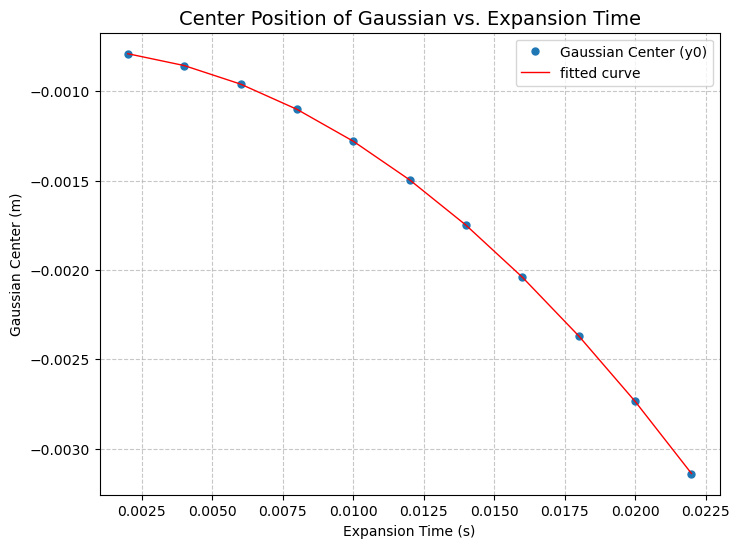

In [10]:
cv = [parabolic(tm, *pt) for tm in t_val]

plt.figure(figsize=(8, 6))
plt.plot(t_val,y_pos,'o', label="Gaussian Center (y0)", markersize=5, linewidth=1)
plt.plot(t_val,cv,'r-', label="fitted curve", markersize=6, linewidth=1)
plt.title("Center Position of Gaussian vs. Expansion Time", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel("Expansion Time (s)", fontsize=10)
plt.ylabel("Gaussian Center (m)", fontsize=10)
plt.legend()
plt.show()





# problem 2

[ 1.27489135e+11  1.57045388e+02  2.60624183e+02  1.33061103e+01
 -1.15918920e+01  2.80767223e+09]


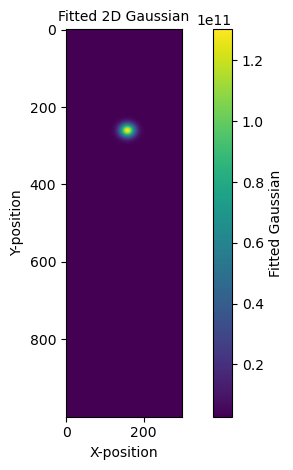

In [11]:
def gaussian_2d(coords, A, x0, y0, sigma_x, sigma_y, offset):
    x,y = coords
        
    exp_term = np.exp(-(((x-x0)**2) / (2 * sigma_x**2) + ((y-y0)**2) / (2 * sigma_y**2)))
  
    return (A * exp_term + offset)

imageData = load_image('A_Thermal_3.bin', resolution_x, resolution_y)
col_density = -np.log(imageData ) / sigma_abs
true_val = col_density.ravel()
ny,nx = col_density.shape
x = np.arange(nx)
y = np.arange(ny)
X, Y = np.meshgrid(x, y)
coordinates = np.vstack([X.ravel(), Y.ravel()])


A_guess = (np.max(true_val) - np.min(true_val) )
x0_guess = np.mean(x)
y0_guess = np.mean(y)
sigmax_guess = np.std(x)
sigmay_guess = np.std(y)
offset_guess = np.min(true_val)

initial_guess = [A_guess, x0_guess,y0_guess, sigmax_guess, sigmay_guess, offset_guess]

popt,pcov = curve_fit(gaussian_2d, coordinates,true_val, p0 = initial_guess )

fitted_data = gaussian_2d(coordinates, *popt).reshape(ny, nx)
print(popt)
plt.imshow(fitted_data)
plt.colorbar(label="Fitted Gaussian" )
plt.title("Fitted 2D Gaussian", fontsize = 10)
plt.xlabel("X-position")
plt.ylabel("Y-position")
plt.tight_layout()
plt.show()

### 2D gaussian fit loop for all images

In [12]:
def fit_fun2d(image_data):
    sigma_abs = 29e-13 
   
    col_density = -np.log(image_data ) / sigma_abs
    true_val = col_density.ravel()
    ny,nx = col_density.shape
    x = np.arange(nx)
    y = np.arange(ny)
    X, Y = np.meshgrid(x, y)
    coordinates = np.vstack([X.ravel(), Y.ravel()])


    A_guess = (np.max(true_val) - np.min(true_val) )
    x0_guess = np.argmax(np.sum(col_density, axis =0))
    y0_guess = np.argmax(np.sum(col_density, axis =1))
    sigmax_guess = nx/10
    sigmay_guess = ny/10
    offset_guess = np.min(true_val)

    initial_guess = [A_guess, x0_guess,y0_guess, sigmax_guess, sigmay_guess, offset_guess]

    popt,pcov = curve_fit(gaussian_2d, coordinates,true_val, p0 = initial_guess )
    return popt

def gaussian_2d(coords, A, x0, y0, sigma_x, sigma_y, offset):
    x,y = coords
        
    exp_term = np.exp(-(((x-x0)**2) / (2 * sigma_x**2) + ((y-y0)**2) / (2 * sigma_y**2)))
  
    return (A * exp_term + offset)
    
    

In [13]:
im_data = []  

for i in range(1, 12):
    t = f'A_Thermal_{i}.bin'  
    data = load_image(t, resolution_x, resolution_y) 
    im_data.append(data) 
optvar2d = []
for image in im_data:
    popt = fit_fun2d(image)
    optvar2d.append(popt)

fit_image = []
for param in optvar2d:
    image = gaussian_2d(coordinates, *param).reshape(ny, nx)
    fit_image.append(image)

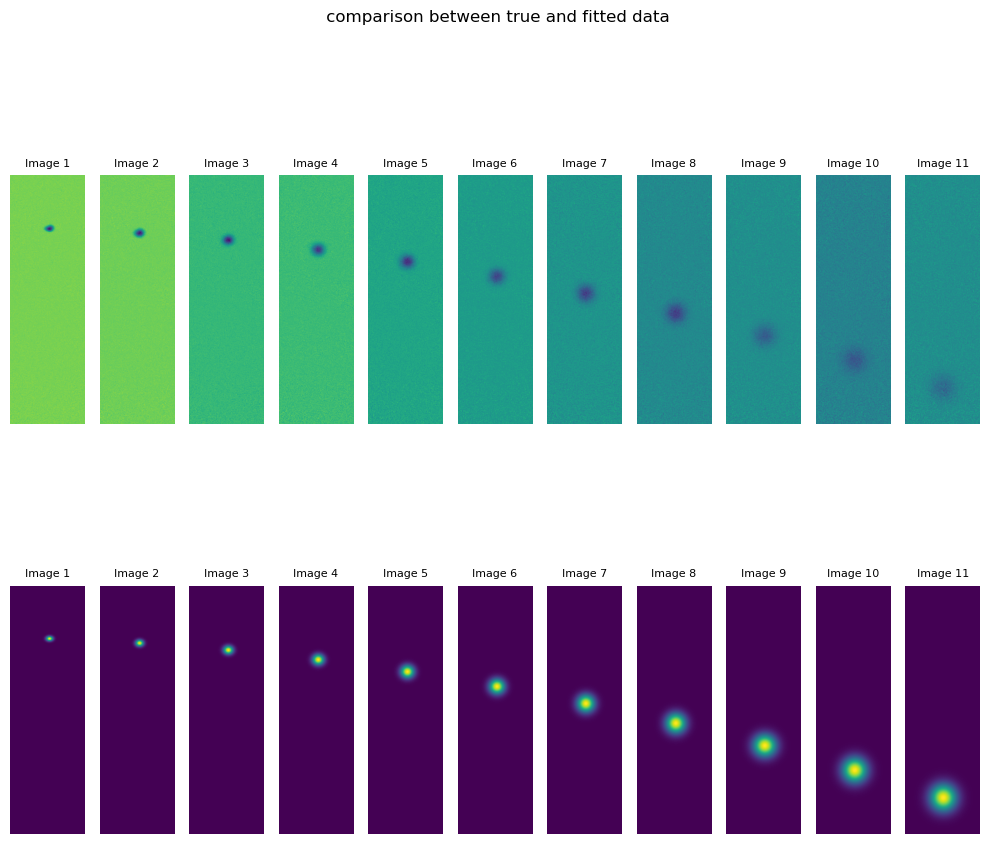

In [14]:

    
fig, axes = plt.subplots(2, 11, figsize=(10, 10)) 
fig.suptitle(' comparison between true and fitted data', x=0.5)
#fig.suptitle(' fitted 2D gaussian', x=1)
 
for i in range (11):
    
    axes[0,i].imshow(im_data[i]) 
    axes[0,i].axis('off') 
    axes[0,i].set_title(f"Image {i+1}", fontsize=8)
   
    axes[1,i].imshow(fit_image[i])  
    axes[1,i].axis('off') 
    axes[1,i].set_title(f"Image {i+1}", fontsize=8)
    
plt.tight_layout()

plt.show() 

### Ellipticity

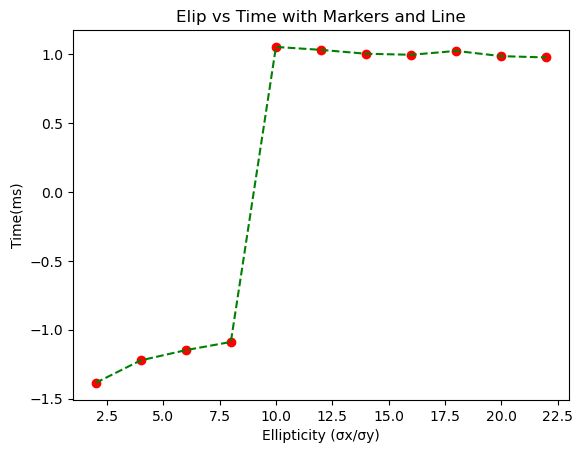

In [15]:
elip = []
for param in optvar2d:
    ellipticity = param[3]/param[4]
    elip.append(ellipticity)

plt.figure
plt.plot(time_val, elip, 'ro'  )
plt.plot (time_val, elip, 'g--')
plt.xlabel('Ellipticity (σx/σy)')
plt.ylabel('Time(ms)')
plt.title('Elip vs Time ')
plt.show()

### tempreture calculation using gaussian width

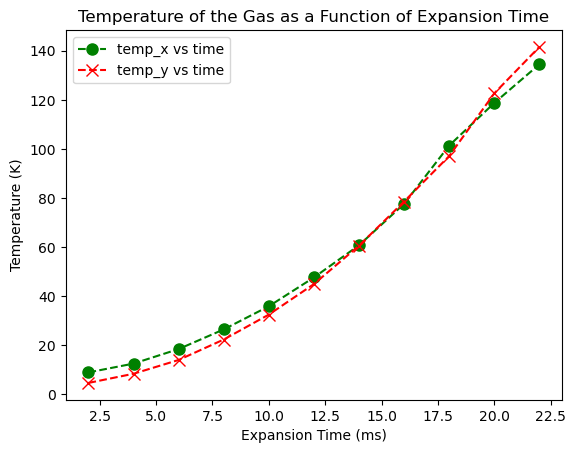

In [16]:
temperatures_x = []
temperatures_y = []
m_Rb = 1.44e-24
k_B = k
for param in optvar2d:
    sigma_x = param[3] 
    temperaturex = (sigma_x**2 * m_Rb) / k_B
    temperatures_x.append(temperaturex)
    sigma_y = param[4] 
    temperaturey = (sigma_y**2 * m_Rb) / k_B
    temperatures_y.append(temperaturey)
plt.figure()
plt.plot(time_val, temperatures_x,'go--', label = 'temp_x vs time', markersize = 8)
plt.plot(time_val, temperatures_y,'rx--', label = 'temp_y vs time', markersize= 8)
plt.xlabel("Expansion Time (ms)")
plt.ylabel("Temperature (K)")
plt.title("Temperature of the Gas as a Function of Expansion Time")
plt.legend()
plt.show()

### number of atoms

In [17]:
atom_number = np.sum(col_density) * (pixel_size ** 2)

print(f"Estimated number of atoms in the cloud: {atom_number}")

Estimated number of atoms in the cloud: 13080.011069880427


## Estimated number of atoms in the cloud: 13080.011069880427